## Combinatorial Promoters

### Overview


The CombinatorialPromoter is supposed to represent the general case where a promoter is transcribable when bound by a specific combination of regulators.

In general, consider a set of $M$ regulators $R_1...R_M$ which bind to the promoter $P$ with cooperativities $n_1...n_M$ ie $n_i$ copies of $R_i$ bind to the promoter at once. The CombinatorialPromoter enumerates all possible bound Promoter-Regulator complexes which are returned as a list of ComplexSpecies using the Combinatorial_Cooperative_Binding Mechanism. These complexes will be default take the following form with the regulators in alphabetical order:

\begin{align}
\textrm{Species}=\{&P, P:n_1\textrm{x}R_1, &&..., P:n_M\textrm{x}R_M, \\
&P:n_1\textrm{x}R_1:n_2\textrm{x}R_2, &&..., P:n_{M-1}\textrm{x}R_{M-1}:n_M\textrm{x}R_M \\
&&. \\
&&. \\
&&. \\
&P:n_1\textrm{x}R_1:n_2\textrm{x}R_2: &&...:n_{M-1}\textrm{x}R_{M-1}:n_M\textrm{x}R_M \}
\end{align}

The Combinatorial_Cooperative_Binding Mechanism in Combinatorial Promoter returns all reactions where a Complex consisting of a promoter and a set of regulators bind to one additional regulator.
\begin{align}
\textrm{Reactions} = 
\{&P + n_1 R_1 \leftrightarrow P:n_1\textrm{x}R_1, ...\\
 &..., P + n_M R_M \leftrightarrow P:n_M\textrm{x}R_M, ... \\
  &..., P:n_1\textrm{x}R_1 + n_2 R_2 \leftrightarrow P:n_1\textrm{x}R_1:n_2\textrm{x}R_2,... \\
  &..., P:n_{M-1}\textrm{x}R_{M-1} + n_M R_M \leftrightarrow P:n_{M-1}\textrm{x}R_{M-1}:n_M\textrm{x}R_M, ... \\
  &. \\
  &. \\
  &. \\
  &..., P:n_1\textrm{x}R_1:n_2\textrm{x}R_2:...:n_{M-1}\textrm{x}R_{M-1} + n_M R_M
  \leftrightarrow
  P:n_1\textrm{x}R_1:n_2\textrm{x}R_2:...:n_{M-1}\textrm{x}R_{M-1}:n_M\textrm{x}R_M
\end{align}

Arbitrary combinations of these regulators can be defined as transcribable using:

    CombinatorialPromoter(name, [Regulators], tx_capable_list = [[Transcribable Combination fo regulators 1], [Combination 2], ...]) 

Additionally, there is the option for leak reactions in which case the free promoter is transcribed at some leak rate.

    CombinatorialPromoter(name, [Regulators], leak = True/False ) 


#### Below are imports required for these examples and plotting.

In [1]:
#Using Bioscrape: Basic Imports
#from bioscrape.types import Model
#from bioscrape.simulator import py_simulate_model
#For arrays and plotting

try:
    import numpy as np
    import pylab as plt
    make_heatmap = True
    import numpy as np
    import pylab as plt
    import bioscrape
    import seaborn as sns
    import pandas as pd
except ModuleNotFoundError:
    make_heatmap = False
    print('please install the plotting libraries: pip install biocrnpyler[all]')

#this is for the network representation
try:
    import bokeh.plotting
    import bokeh.io
    bokeh.io.output_notebook()
    plotCRN = True
except (ModuleNotFoundError,ImportError) as e:
    plotCRN = False
    print('please install the plotting libraries: pip install biocrnpyler[all]')


Loading BokehJS ...

### Example 1: Default Behavior to Produce AND logic with leak
In the following example, we consider a promoter phrpL which can be bound by the proteins hrpR and hrpS. When both proteins are present, transcription is activated, but when one or the other (or none) is present, transcription is not activated.

In [2]:
from biocrnpyler.components import Protein, DNAassembly, CombinatorialPromoter
from biocrnpyler.mixtures import TxTlExtract
#these are the additional parameters that you need:
parameters = {
    (None, 'phrpL_hrpR', 'cooperativity'): 1.0, #default is 2, but these proteins bind at cooperativity = 1
    (None, 'phrpL_hrpS', 'cooperativity'): 1.0, 
    (None, 'phrpL_hrpR', 'ku'):50, #these are the regulator unbinding rates
    (None, 'phrpL_hrpS', 'ku'):50,
    (None, 'phrpL_leak', 'ktx'): 0.01,  #this is the leak rate
    (None, 'phrpL_leak', 'ku'): 100, #this is the leak polymerase unbinding rate

    ('translation_mm', 'B0030', 'ku'): 10.0, #Unbinding
    ('translation_mm', 'B0030', 'ktl'): 1.5, #Translation Rate

    "kb":100, "ku":10, "ktx":.05, "ktl":.2, "kdeg":2 #some default parameters
}
#above you can see the desired part_id is very simple. The general syntax is <promoter.name>_<regulator.name>.
#using this syntax you can define the strength of binding of each regulator to the promoter.
#cooperativity between different regulators is not supported.

#you can also define the transcription rate and binding and unbinding (kb or ku) of polymerase from a transcribable
#complex. A transcribable complex is a promoter with regulators bound that is capable of transcription.

#By default, all combinations of regulators bound will be capable of transcription. They will use the "ktx" parameter
#promoter with nothing bound will use the phrpL_leak parameter


#now we define the proteins. Their names should match what you put in the promoter, below
hrpR = Protein("hrpR")
hrpS = Protein("hrpS")

#Define the promoter

#this is an "AND gate" promoter. That means that it only leads to transcript if both regulators are bound
#binding of one or the other regulator should not lead to any transcription
#this is the network:
# hrpR + mydna <--> mydna:hrpR
# hrpS + mydna <--> mydna:hrpS
# hrpR + mydna:hrpS <--> mydna:hrpR:hrpS
# hrpS + mydna:hrpR <--> mydna:hrpR:hrpS

phrpL = CombinatorialPromoter("phrpL", regulators=["hrpR","hrpS"], leak=True) 
#this defines a promoter which binds hrpR and hrpS, and it leaks. 
#By default, leak only happens when there is nothing bound to the DNA.
#this also means that in this promoter, individually bound species (with only one regulator) will not lead to
#any transcription! This means they will not leak also.

#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL, rbs="B0030", protein="GFP")

#TxTl Extract is a Mixture with more complex internal models
extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS], 
                             parameters=parameters, parameter_file = "default_parameters.txt", 
                             overwrite_parameters = True) #Overwrite parameters will overwrite the parameters in the file with the dictionary
CRN_extract_1 = extract_1_TXTL.compile_crn()

print("The species and reactions in the CRN:\n", CRN_extract_1.pretty_print())


The species and reactions in the CRN:
 Species(N = 18) = {
protein[RNAase] (@ 6.0),  
   found_key=(mech=None, partid=e coli extract 1, name=RNAase).
   search_key=(mech=initial concentration, partid=e coli extract 1, name=RNAase).
complex[protein[Ribo]:rna[mydna]] (@ 0),  complex[protein[RNAase]:rna[mydna]] (@ 0),  rna[mydna] (@ 0),  dna[mydna] (@ 0),  protein[hrpS] (@ 0),  protein[hrpR] (@ 0),  complex[dna[mydna]:protein[hrpS]] (@ 0),  complex[dna[mydna]:protein[hrpR]:protein[hrpS]] (@ 0),  complex[dna[mydna]:protein[hrpR]] (@ 0),  complex[dna[mydna]:protein[RNAP]] (@ 0),  complex[complex[protein[Ribo]:rna[mydna]]:protein[RNAase]] (@ 0),  complex[complex[dna[mydna]:protein[hrpS]]:protein[RNAP]] (@ 0),  complex[complex[dna[mydna]:protein[hrpR]:protein[hrpS]]:protein[RNAP]] (@ 0),  complex[complex[dna[mydna]:protein[hrpR]]:protein[RNAP]] (@ 0),  protein[Ribo] (@ 0),  protein[RNAP] (@ 0),  protein[GFP] (@ 0),  
}

Reactions (18) = [
0. dna[mydna]+protein[RNAP] <--> complex[dna[mydna]:pr

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "


In [3]:
from biocrnpyler.utils.plotting import generate_networkx_graph, graphPlot
#below is CRN plotting code. set plotCRN to False to disable
if plotCRN:
    DG, DGspec, DGrxn = generate_networkx_graph(CRN_extract_1)
    plot = Plot(width=500, height=500, x_range=Range1d(-500, 500), y_range=Range1d(-500, 500))
    graphPlot(DG, DGspec, DGrxn, plot)
    bokeh.io.show(plot)

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:166: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  reaction_renderer = from_networkx(DGreactions, positions, center=(0, 0))
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\utils\plotting.py:167: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  species_renderer = from_networkx(DGspecies, positions, center=(0, 0))


{(None, 'phrpL_hrpR', 'cooperativity'): 1.0, (None, 'phrpL_hrpS', 'cooperativity'): 1.0, (None, 'phrpL_hrpR', 'ku'): 50, (None, 'phrpL_hrpS', 'ku'): 50, (None, 'phrpL_leak', 'ktx'): 0.01, (None, 'phrpL_leak', 'ku'): 100, ('translation_mm', 'B0030', 'ku'): 10.0, ('translation_mm', 'B0030', 'ktl'): 1.5, 'kb': 100, 'ku': 10, 'ktx': 0.05, 'ktl': 0.2, 'kdeg': 2}


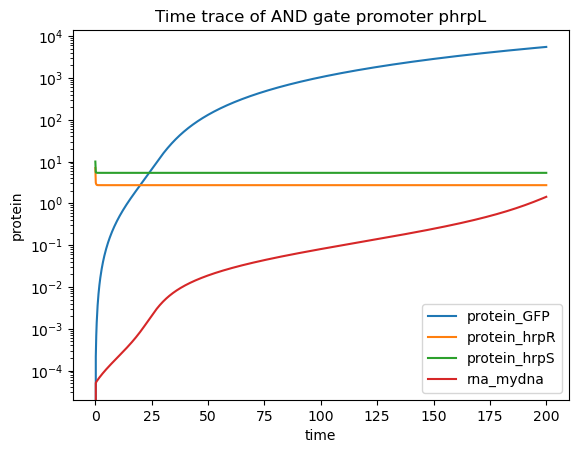

In [4]:
if plotCRN:
    #this is just a normal time trace of the model, with both proteins present
    timepoints = np.linspace(0, 200, 1000)
    x0 = {"dna_mydna":5.0, "protein_hrpS":10, "protein_hrpR":7, "protein_RNAP":10., "protein_Ribo":50.,}
    Re1 = CRN_extract_1.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
    if Re1 is not None:
        plt.plot(timepoints,Re1["protein_GFP"], label = "protein_GFP")
        plt.plot(timepoints,Re1["protein_hrpR"], label = "protein_hrpR")
        plt.plot(timepoints,Re1["protein_hrpS"], label = "protein_hrpS")
        plt.plot(timepoints,Re1["rna_mydna"], label = "rna_mydna")
        plt.gca().set_yscale("log")
        plt.title("Time trace of AND gate promoter phrpL")
        plt.xlabel("time")
        plt.ylabel("protein")
        plt.legend()
    print(parameters)

#### Vary hrpR and hrpS
To really test the combinatorial promoter we will vary the concentrations of hrpR and hrpS.

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,


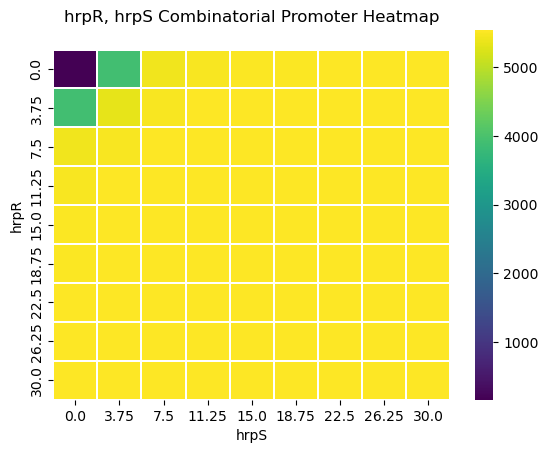

In [5]:
if(make_heatmap):
    #aggregator data frame
    GFP_data = []
    #Different initial values of R and S
    conc_hrpR = np.linspace(0, 30, 9)
    conc_hrpS = np.linspace(0, 30, 9)


    for conc_R in conc_hrpR:
        x0["protein_hrpR"] = conc_R
        for conc_S in conc_hrpS:
            x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
            Re1 = CRN_extract_1.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            #now we are simulating over and over again, but only taking the final protein_GFP value
            if Re1 is not None:
                GFP_data.append( 
                    {'hrpS_conc':conc_S, 'hrpR_conc':conc_R,
                     'GFP_max': Re1["protein_GFP"].values[-1]})
    GFP_max = pd.DataFrame(GFP_data, columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])
    
    #now, you make a 2d plot with all the data
    if GFP_max is not None:
        data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
                    columns = 'hrpR_conc',
                    values = 'GFP_max')

        ax = sns.heatmap(data,
                        cmap = 'viridis',
                        linewidths=.2)
        ax.set_ylim(9,-0.5) #not sure why this is needed

        ax.set(xlabel='hrpS', ylabel='hrpR')
        ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")


#### Improving the AND Logic Model using the tx_capable_list keyword and more detailed parameters

After careful inspection of the above heatmap, you might notice two important features:

1) The promoter is on at all times except when no regulators are present

2) the promoter is on very strongly for most possible concentrations

We will adjust this model by changing the parameters and adding additional transcribable states

1) increase the unbinding rate

2) define single regulator bound promoters as being "leak"

To do this, we will use the tx_capable_list keyword and modify the list of parameters

    phrpL = CombinatorialPromoter(... tx_capable_list = [["hrpR","hrpS"]] ...)

Notice that there are 3 transcribable states, each regulator bound individually and both regulators bound together. Each of these combination of regulators requires their own parameters which are seen below in the newparam dictionary.

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this

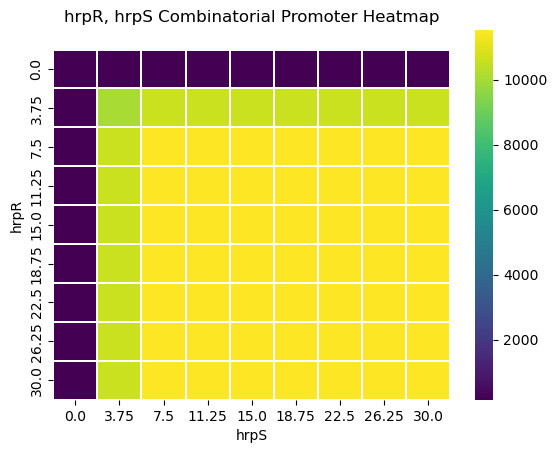

In [6]:
newparam = {
    (None, 'phrpL_hrpR', 'cooperativity'): 1.0, 
    (None, 'phrpL_hrpS', 'cooperativity'): 1.0, 
    (None, 'phrpL_hrpR','ku'):5, #unbinding rate of each regulator
    (None, 'phrpL_hrpS','ku'):5,
    (None, 'phrpL_hrpR_hrpS_RNAP', 'ktx'): 0.17025, #these are the rates for the correctly bound promoter
    (None, 'phrpL_hrpR_hrpS_RNAP', 'ku'): 11.01321586,
    (None, 'phrpL_leak','ktx'):0.01, #this is the leak transcription rate
    (None, 'phrpL_leak', 'ku'): 100.,#this unbinding rate is now needed because we changed the tx_capable_list. Transcription from singly bound promoter uses the default "ktx"
}

#WARNING!!!
#out of order regulators will not work! For example, phrpL_hrpR_hrpS_RNAP is correct, but phrpL_hrpS_hrpR_RNAP is not.

parameters.update(newparam)
#you can also define the ktx for the leak reaction. I don't think this is necessary
#    ('phrpL_hrpR_RNAP', 'ktx'): 0.17, 
#    ('phrpL_hrpS_RNAP', 'ktx'): 0.17,

phrpL = CombinatorialPromoter("phrpL",["hrpR","hrpS"], 
                              tx_capable_list = [[Species("hrpR",material_type="protein"),"hrpS"]], #species can also be used
                              leak=True) 
#now we are saying that there are more species that are capable of transcribing. Specifically, that we 
#can still transcribe when both are bound, but also when one or the other is bound.

#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL,rbs="B0030",protein="GFP")

extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS],
                             parameters=parameters, parameter_file = "default_parameters.txt",
                             overwrite_parameters = True) #Overwrite parameters will overwrite the parameters in the file with the dictionary
CRN_extract_1 = extract_1_TXTL.compile_crn()

if(make_heatmap):
    #aggregator data frame
    GFP_data = []
    #Different initial values of R and S
    conc_hrpR = np.linspace(0, 30, 9)
    conc_hrpS = np.linspace(0, 30, 9)


    for conc_R in conc_hrpR:
        x0["protein_hrpR"] = conc_R 
        for conc_S in conc_hrpS:
            x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
            Re1 = CRN_extract_1.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            #now we are simulating over and over again, but only taking the final protein_GFP value
            GFP_data.append({'hrpS_conc':conc_S,
                            'hrpR_conc':conc_R,
                            'GFP_max': Re1["protein_GFP"].values[-1]})
    GFP_max = pd.DataFrame(GFP_data, columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])

    #now, you make a 2d plot with all the data
    data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
                columns = 'hrpR_conc',
                values = 'GFP_max')

    ax = sns.heatmap(data,
                    cmap = 'viridis',
                    linewidths=.2)
    ax.set_ylim(9,-0.5) #not sure why this is needed

    ax.set(xlabel='hrpS', ylabel='hrpR')
    ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")

### Example 2: Using the tx_capable_list keyword to implement XOR logic
In the following example, we consider a promoter phrpL which can be bound by the proteins hrpR and hrpS. When either one  proteins or the other is present, but not both, transcription is activated. To do this, we pass in the following combinations to transcribable list:

    phrpL = CombinatorialPromoter(... tx_capable_list = [["hrpR"],["hrpS"]] ...)

This ensures that only when hrpR or hrpS is individually bound to the promoter can it be transcribed.

C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\parameter.py:507: UserWarning: parameter file contains no unit column! Please add a column named ['unit', 'units'].
  warn(f"parameter file contains no {accepted_name} column! Please add a "
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  result = py_simulate_model(timepoints, Model = m, stochastic = stochastic, safe = safe,
C:\Users\ayush\Box\Research\bioCRNpyler\biocrnpyler\core\chemical_reaction_network.py:369: ODEintWarning: Excess work done on this

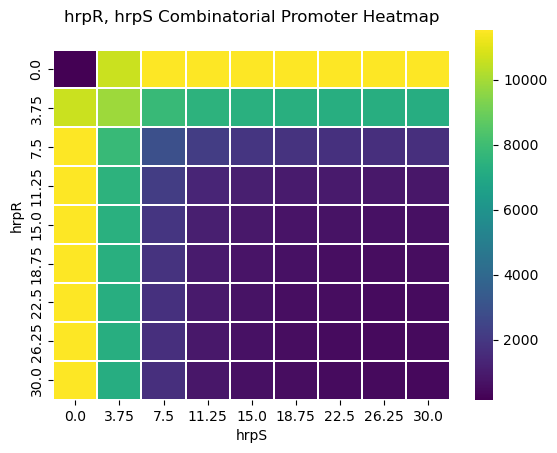

In [7]:
newparam = {
    (None, 'phrpL_hrpR', 'cooperativity'): 1.0, 
    (None, 'phrpL_hrpS', 'cooperativity'): 1.0, 
    (None, 'phrpL_hrpR','ku'):3, #we have to massively decrease the unbinding rate to make this xor gate work
    (None, 'phrpL_hrpS','ku'):3,
    #(None, 'phrpL_hrpR_hrpS_RNAP', 'ku'): 100, #this time, this one is leak
    (None, 'phrpL_hrpR_RNAP', 'ktx'): 0.17, #these are now transcribing at high rates!
    (None, 'phrpL_hrpS_RNAP', 'ktx'): 0.17,
    (None, 'phrpL_hrpS_RNAP', 'ku'): 11.,
    (None, 'phrpL_hrpR_RNAP', 'ku'): 11,
    (None, 'phrpL','ku'):100,
    
}

parameters.update(newparam)
phrpL = CombinatorialPromoter("phrpL",["hrpR","hrpS"], 
                              tx_capable_list = [["hrpR"],["hrpS"]],
                              leak=True) 
#this is our DNA
dna = DNAassembly("mydna",promoter=phrpL,rbs="B0030",protein="GFP")

extract_1_TXTL = TxTlExtract(name = "e coli extract 1", components = [dna,hrpR,hrpS], \
                             parameters=parameters, parameter_file = "default_parameters.txt",
                             overwrite_parameters = True) #Overwrite parameters will overwrite the parameters in the file with the dictionary

CRN_extract_1 = extract_1_TXTL.compile_crn()


if(make_heatmap):
    #aggregator data frame
    GFP_data = []
    #Different initial values of R and S
    conc_hrpR = np.linspace(0,30, 9)
    conc_hrpS = np.linspace(0, 30, 9)
    for conc_R in conc_hrpR:
        x0["protein_hrpR"] = conc_R 
        for conc_S in conc_hrpS:
            x0["protein_hrpS"] = conc_S #Change my initial condition dictionary
            Re1 = CRN_extract_1.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0)
            #now we are simulating over and over again, but only taking the final protein_GFP value
            GFP_data.append({'hrpS_conc':conc_S,
                            'hrpR_conc':conc_R,
                            'GFP_max': Re1["protein_GFP"].values[-1]})
    GFP_max = pd.DataFrame(GFP_data, columns = ['hrpS_conc', 'hrpR_conc', 'GFP_max'])

    #now, you make a 2d plot with all the data
    data = pd.pivot_table(data = GFP_max, index = 'hrpS_conc',
                columns = 'hrpR_conc',
                values = 'GFP_max')

    ax = sns.heatmap(data,
                    cmap = 'viridis',
                    linewidths=.2)
    ax.set_ylim(9,-0.5) #not sure why this is needed

    ax.set(xlabel='hrpS', ylabel='hrpR')
    ax.set_title("hrpR, hrpS Combinatorial Promoter Heatmap")

In [8]:
# End